In [1]:
import pandas as pd
import os
import numpy as np
import csv
from matplotlib import pyplot as plt

import pydicom
import glob
import natsort
import cv2

import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.model_selection import train_test_split
from PIL import Image

import keras
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D
from keras.applications import resnet50, inception_v3, vgg16, densenet
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.optimizers import Adam, SGD
import tensorflow as tf

from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc
from sklearn.cluster import KMeans

from keras.applications.resnet50 import preprocess_input
from scipy import interp
from itertools import cycle


import pickle

Using TensorFlow backend.


# Import DCM files

### PD vs Control patient data

Load scans of patients, y = [0,1] based on PD or Control

In [2]:
sorted(glob.glob('dcm_arrays_mid/*.pickle'))

['dcm_arrays_mid/chunk0-1330.pickle',
 'dcm_arrays_mid/chunk1330-2660.pickle',
 'dcm_arrays_mid/chunk2660-3990.pickle',
 'dcm_arrays_mid/chunk3990-5320.pickle',
 'dcm_arrays_mid/chunk5320-6650.pickle']

In [3]:
def normalize(arr):
    """
    Linear normalization
    http://en.wikipedia.org/wiki/Normalization_%28image_processing%29
    """
    arr = arr.astype('float')
    
    minval = np.min(arr)
    maxval = np.max(arr)
    arr -= minval
    arr *= (255.0/(maxval-minval))
    return arr

In [4]:
with open('dcm_arrays_mid/chunk0-1330.pickle', 'rb') as handle:
    dcm_array = pickle.load(handle)
    
X_chunk = dcm_array['x']
Y_chunk = dcm_array['y']
path_chunk = dcm_array['paths']

In [5]:
with open('dcm_arrays_mid/chunk1330-2660.pickle', 'rb') as handle:
    dcm_array = pickle.load(handle)
    
X_chunk_2 = dcm_array['x']
Y_chunk_2 = dcm_array['y']
path_chunk_2 = dcm_array['paths']

In [6]:
with open('dcm_arrays_mid/chunk2660-3990.pickle', 'rb') as handle:
    dcm_array = pickle.load(handle)
    
X_chunk_3 = dcm_array['x']
Y_chunk_3 = dcm_array['y']
path_chunk_3 = dcm_array['paths']

In [7]:
with open('dcm_arrays_mid/chunk5320-6650.pickle', 'rb') as handle:
    dcm_array = pickle.load(handle)
    
X_chunk_5 = dcm_array['x']
Y_chunk_5 = dcm_array['y']
path_chunk_5 = dcm_array['paths']

In [8]:
with open('dcm_arrays_mid/chunk3990-5320.pickle', 'rb') as handle:
    dcm_array = pickle.load(handle)
    
X_chunk_4 = dcm_array['x']
Y_chunk_4 = dcm_array['y']
path_chunk_4 = dcm_array['paths']

In [9]:
X_norm = []
for arr in X_chunk:
    norm = normalize(arr) # [:,:,0]
    X_norm.append(norm)

In [10]:
X_norm_2 = []
for arr in X_chunk_2:
    norm = normalize(arr) # [:,:,0]
    X_norm_2.append(norm)

In [11]:
X_norm_3 = []
for arr in X_chunk_2:
    norm = normalize(arr) # [:,:,0]
    X_norm_3.append(norm)

In [12]:
X_norm_4 = []
for arr in X_chunk_4:
    norm = normalize(arr) # [:,:,0]
    X_norm_4.append(norm)

In [13]:
X_norm_5 = []
for arr in X_chunk_5:
    norm = normalize(arr) # [:,:,0]
    X_norm_5.append(norm)

In [14]:
X_norm = np.array(X_norm)

In [15]:
# np.min(X_norm_4), np.max(X_norm_4)

In [16]:
X_norm_2 = np.array(X_norm_2)
X_norm_3 = np.array(X_norm_3)
X_norm_3 = np.array(X_norm_4)
X_norm_3 = np.array(X_norm_5)

In [17]:
# np.min(X_comb_pd_c), np.max(X_comb_pd_c)

In [18]:
X_comb_pd_c = np.concatenate((X_norm, X_norm_2, X_norm_3, X_norm_4, X_norm_5), axis=0)
Y_comb_pd_c = np.concatenate((Y_chunk, Y_chunk_2, Y_chunk_3, Y_chunk_4, Y_chunk_5), axis=0)
X_comb_pd_c.shape, Y_comb_pd_c.shape

((6650, 256, 256, 3), (6650,))

In [19]:
np.min(X_comb_pd_c), np.max(X_comb_pd_c)

(0.0, 255.00000000000003)

In [20]:
X_pre_pd_c = preprocess_input(X_comb_pd_c)

In [21]:
flips = []
Y = []
for i, scan in enumerate(X_pre_pd_c):
#     print(i, scan.shape)
    new = scan[:, :, 0]
#     print(new.shape)
    new_flipped = np.fliplr(new)
#     print(new_flipped.shape)
    new_flipped = new_flipped.reshape(256, 256, 1)
    new_flipped = np.repeat(new_flipped[..., np.newaxis], 3, -1)
    flips.append(new_flipped)
    Y.append(Y_comb_pd_c[i])

### Stage Patient Data

Load scans of patients, y = [0,1,2,3] based on stage 0, 1, 2, 3

In [101]:
sorted(glob.glob('dcm_stage_arrays_mid/*.pickle'))

['dcm_stage_arrays_mid/chunk0-1330.pickle',
 'dcm_stage_arrays_mid/chunk1330-2660.pickle',
 'dcm_stage_arrays_mid/chunk2660-3990.pickle',
 'dcm_stage_arrays_mid/chunk3990-5320.pickle',
 'dcm_stage_arrays_mid/chunk5320-6650.pickle']

In [102]:
with open('dcm_stage_arrays_mid/chunk0-1330.pickle', 'rb') as handle:
    dcm_array = pickle.load(handle)
    
X_stage_chunk = dcm_array['x']
Y_stage_chunk = dcm_array['y']
path_chunk = dcm_array['paths']

In [103]:
with open('dcm_stage_arrays_mid/chunk1330-2660.pickle', 'rb') as handle:
    dcm_array = pickle.load(handle)
    
X_stage_chunk_2 = dcm_array['x']
Y_stage_chunk_2 = dcm_array['y']
path_chunk_2 = dcm_array['paths']

In [104]:
with open('dcm_stage_arrays_mid/chunk2660-3990.pickle', 'rb') as handle:
    dcm_array = pickle.load(handle)
    
X_stage_chunk_3 = dcm_array['x']
Y_stage_chunk_3 = dcm_array['y']
path_chunk_3 = dcm_array['paths']

In [109]:
with open('dcm_stage_arrays_mid/chunk3990-5320.pickle', 'rb') as handle:
    dcm_array = pickle.load(handle)
    
X_stage_chunk_4 = dcm_array['x']
Y_stage_chunk_4 = dcm_array['y']
path_chunk_4 = dcm_array['paths']

In [110]:
with open('dcm_stage_arrays_mid/chunk5320-6650.pickle', 'rb') as handle:
    dcm_array = pickle.load(handle)
    
X_stage_chunk_5 = dcm_array['x']
Y_stage_chunk_5 = dcm_array['y']
path_chunk_5 = dcm_array['paths']

In [111]:
X_comb = np.concatenate((X_stage_chunk, X_stage_chunk_2, X_stage_chunk_3, X_stage_chunk_4, X_stage_chunk_5), axis=0)
Y_comb = np.concatenate((Y_stage_chunk, Y_stage_chunk_2, Y_stage_chunk_3, Y_stage_chunk_4, Y_stage_chunk_5), axis=0)
X_comb.shape, Y_comb.shape

((6650, 256, 256, 3), (6650,))

In [112]:
X_pre = preprocess_input(X_comb)

In [30]:
X_pre_pd_c = preprocess_input(X_comb_pd_c)

In [24]:
np.min(X_pre_pd_c), np.max(X_pre_pd_c)

(-123.68, 151.06100000000004)

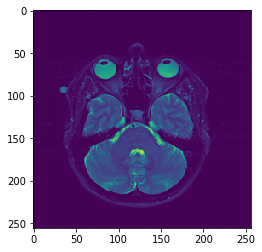

In [308]:
plt.imshow(X_pre_pd_c[60][:, :, 0])

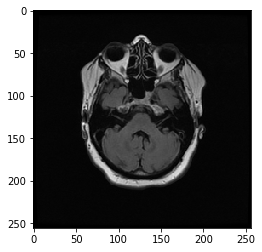

In [319]:
flips = []
Y
for i, scan in enumerate(X_pre_pd_c):
    new = scan[:, :, 0]
    new_flipped = np.fliplr(new)
    new_flipped = new_flipped.reshape(256, 256, 3)
    flips.append(new_flipped)
    Y.append(y[i])

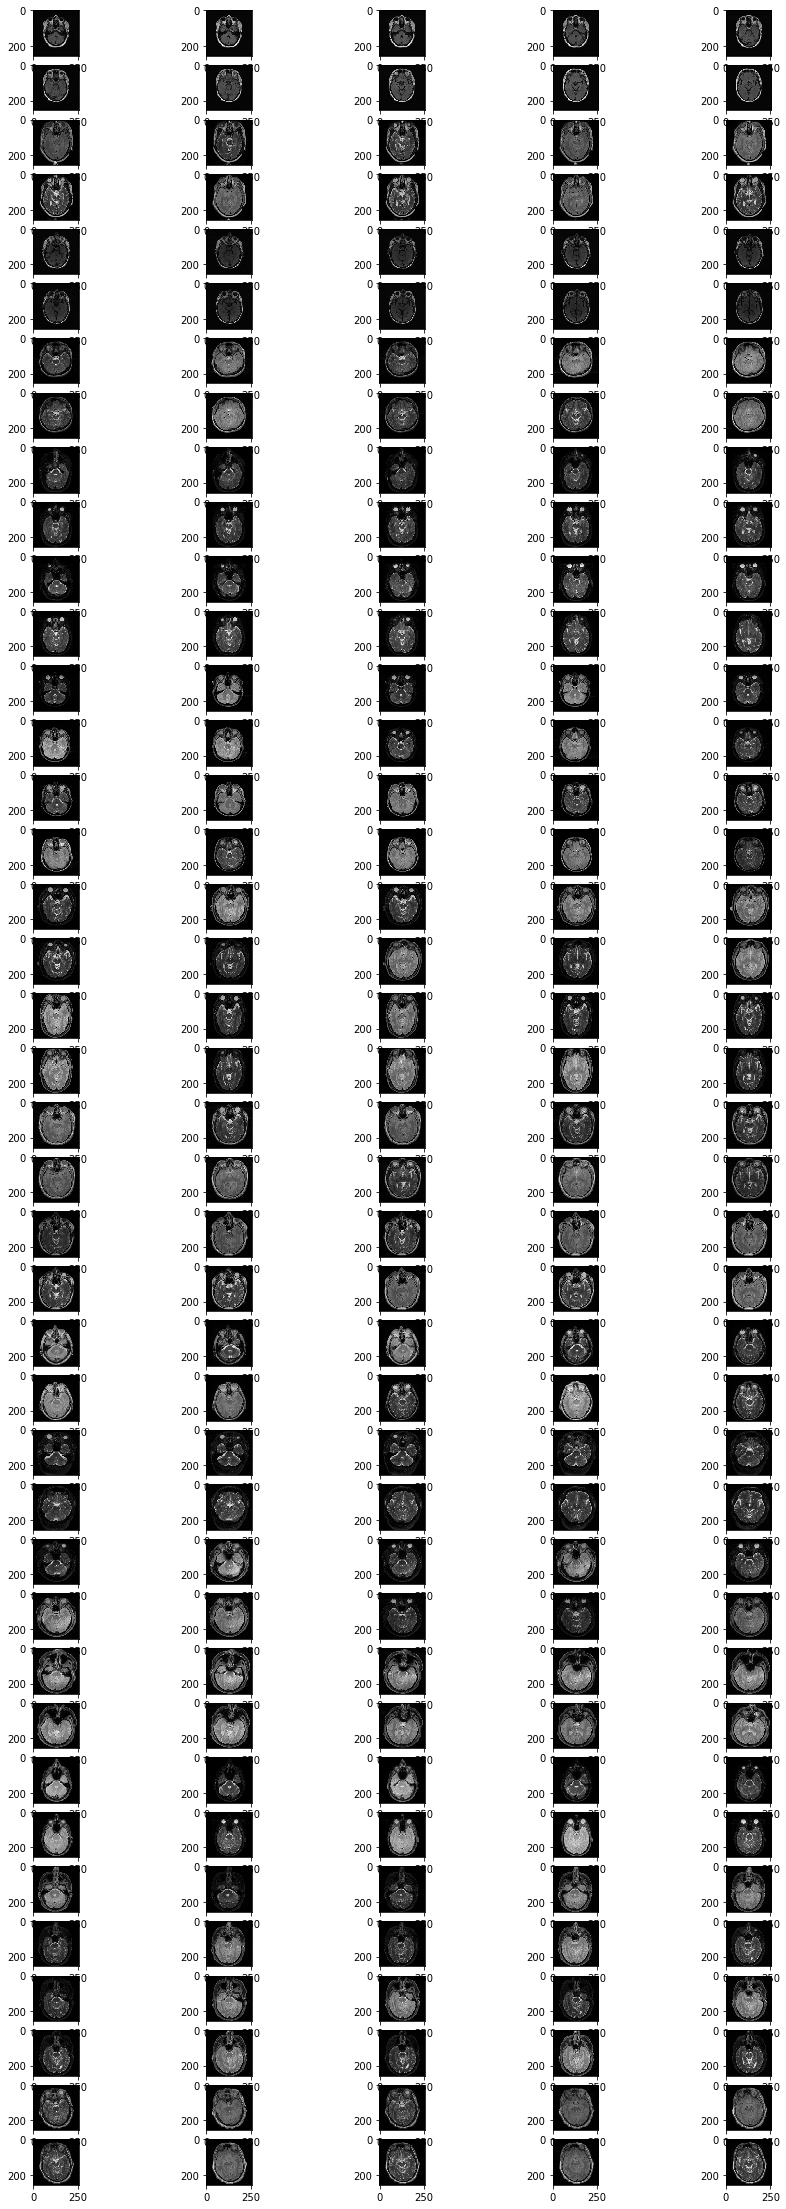

In [314]:
plt.figure(figsize=(15,40))
plt.axes().set_aspect('equal', 'datalim')
plt.set_cmap(plt.gray())
for i in range(200):
    plt.subplot(40, 5,i+1)
    plt.imshow(X_pre_pd_c[i][:, :, 0])
plt.show()

# Model ResNet50 on PD vs Control

In [225]:
batch_size = 20
num_classes = 2

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_pre_pd_c, Y_comb_pd_c, test_size=0.2)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [227]:
X_train.shape, y_train.shape

((5320, 256, 256, 3), (5320, 2))

In [226]:
base_model = resnet50.ResNet50
#base_model = inception_v3.InceptionV3
# base_model = vgg16.VGG16

base_model = base_model(weights='imagenet', include_top=False, input_shape=(256,256,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
# x = Dense(512, activation='relu')(x)
# x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['acc'])


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [228]:
filepath="resnet50midcheckpoints/weights-mid-{epoch:02d}-{acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
model.fit(X_train, y_train, epochs=15, batch_size = batch_size, callbacks=callbacks_list)

In [229]:
model.load_weights('resnet50midcheckpoints/weights-mid-15-0.92.hdf5')

In [52]:
model.fit(X_train, y_train, epochs=15, batch_size = batch_size, callbacks=callbacks_list)

Epoch 1/15
5320/5320 [==============================] - 57s 11ms/step - loss: 0.2510 - acc: 0.8985

Epoch 00001: acc improved from 0.88947 to 0.89850, saving model to resnet50midcheckpoints/weights-mid-01-0.90.hdf5
Epoch 2/15
5320/5320 [==============================] - 58s 11ms/step - loss: 0.2407 - acc: 0.9000

Epoch 00002: acc improved from 0.89850 to 0.90000, saving model to resnet50midcheckpoints/weights-mid-02-0.90.hdf5
Epoch 3/15
5320/5320 [==============================] - 58s 11ms/step - loss: 0.2318 - acc: 0.9028

Epoch 00003: acc improved from 0.90000 to 0.90282, saving model to resnet50midcheckpoints/weights-mid-03-0.90.hdf5
Epoch 4/15
5320/5320 [==============================] - 58s 11ms/step - loss: 0.2421 - acc: 0.8957

Epoch 00004: acc did not improve from 0.90282
Epoch 5/15
5320/5320 [==============================] - 58s 11ms/step - loss: 0.2246 - acc: 0.9019

Epoch 00005: acc did not improve from 0.90282
Epoch 6/15
5320/5320 [==============================] - 58s 11m

In [230]:
y_score = model.predict(X_test)

In [231]:
y_test_flat = []
for i in range(len(y_test)):
    y_test_flat.append(np.where(y_test[i]==1)[0][0])
    
y_classes = y_score.argmax(axis=-1)

In [232]:
y_classes

array([0, 1, 0, ..., 1, 0, 1])

In [233]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_flat, y_classes)
auc_keras = auc(fpr_keras, tpr_keras)

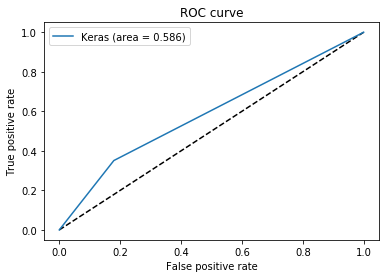

In [234]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

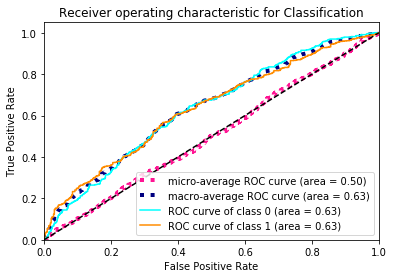

In [235]:
# fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_out)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Classification')
plt.legend(loc="lower right")
plt.show()

In [236]:
y_classes = y_score.argmax(axis=-1)

In [237]:
y_classes, len(y_classes)

(array([0, 1, 0, ..., 1, 0, 1]), 1330)

In [238]:
error = 0
for i in range(len(y_classes)):
    y_pred = y_classes[i]
    y_actual = np.where(y_test[i]==1)
    if y_pred != y_actual:
        error += 1
    
print('Error Rate for PD vs Control: ', error/len(y_classes))

Error Rate for PD vs Control:  0.4992481203007519


# VGG on PD vs Control

# ResNet 50 on Stages

In [169]:
batch_size = 20
num_classes = 4

In [202]:
# X_train_stage, X_test_stage, y_train_stage, y_test_stage = train_test_split(X_pre, Y_comb, test_size=0.2)
X_train_stage, X_test_stage, y_train_stage, y_test_stage = X_pre[:6080], X_pre[6081:], Y_comb[:6080], Y_comb[6081:]
y_train_stage = to_categorical(y_train_stage)
y_test_stage = to_categorical(y_test_stage)

In [203]:
y_train_stage = np.append(y_train_stage, np.zeros([len(y_train_stage),1]),1)

In [204]:
# y_train_stage = y_train_stage.reshape(-1, 4)
y_train_stage.shape

(6080, 4)

In [205]:
X_test_stage.shape, y_test_stage.shape

((569, 256, 256, 3), (569, 4))

In [206]:
base_model = resnet50.ResNet50
#base_model = inception_v3.InceptionV3
# base_model = vgg16.VGG16

base_model = base_model(weights='imagenet', include_top=False, input_shape=(256,256,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
# x = Dense(512, activation='relu')(x)
# x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['acc'])


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [207]:
filepath="resnet50stagecheckpoints/weights-50-{epoch:02d}-{acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [208]:
model.fit(X_train_stage, y_train_stage, epochs=20, batch_size = batch_size, callbacks=callbacks_list)

Epoch 1/20
6080/6080 [==============================] - 72s 12ms/step - loss: 1.0222 - acc: 0.4809

Epoch 00001: acc improved from -inf to 0.48092, saving model to resnet50stagecheckpoints/weights-50-01-0.48.hdf5
Epoch 2/20
6080/6080 [==============================] - 66s 11ms/step - loss: 0.8866 - acc: 0.5870

Epoch 00002: acc improved from 0.48092 to 0.58701, saving model to resnet50stagecheckpoints/weights-50-02-0.59.hdf5
Epoch 3/20
6080/6080 [==============================] - 66s 11ms/step - loss: 0.8026 - acc: 0.6344

Epoch 00003: acc improved from 0.58701 to 0.63438, saving model to resnet50stagecheckpoints/weights-50-03-0.63.hdf5
Epoch 4/20
6080/6080 [==============================] - 66s 11ms/step - loss: 0.7449 - acc: 0.6707

Epoch 00004: acc improved from 0.63438 to 0.67072, saving model to resnet50stagecheckpoints/weights-50-04-0.67.hdf5
Epoch 5/20
6080/6080 [==============================] - 66s 11ms/step - loss: 0.6965 - acc: 0.6995

Epoch 00005: acc improved from 0.67072 

In [209]:
model.load_weights('resnet50stagecheckpoints/weights-50-20-0.93.hdf5')

In [210]:
y_score = model.predict(X_test_stage)
y_test_flat = []
for i in range(len(y_test_stage)):
    y_test_flat.append(np.where(y_test[i]==1)[0][0])
    
y_classes_stage = y_score.argmax(axis=-1)

In [211]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_flat, y_classes_stage)
auc_keras = auc(fpr_keras, tpr_keras)

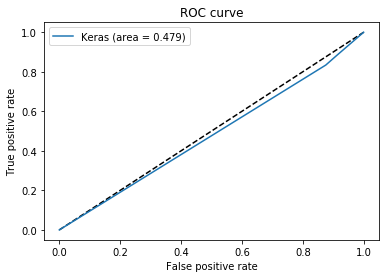

In [212]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [213]:
error = 0
for i in range(len(y_test_stage)):
    y_pred = y_classes[i]
    y_actual = np.where(y_test_stage[i]==1)
    if y_pred != y_actual:
        error += 1
    
print('Error Rate for Stages: ', error/len(y_classes))

Error Rate for Stages:  0.33157894736842103


In [214]:
len(y_test_stage.ravel()), len(y_score.ravel())

(2276, 2276)

In [215]:
y_score

array([[6.5847591e-05, 5.7498278e-07, 9.9993360e-01, 8.3991169e-15],
       [2.7642513e-04, 1.4670918e-06, 9.9972206e-01, 4.6681036e-15],
       [3.2058880e-02, 3.9081632e-10, 9.6794116e-01, 3.4423461e-16],
       ...,
       [5.1040924e-03, 3.3389234e-08, 9.9489588e-01, 1.9344410e-16],
       [2.3277998e-03, 5.3594817e-08, 9.9767214e-01, 1.2782101e-15],
       [8.8242734e-05, 2.5157498e-11, 9.9991179e-01, 2.8274345e-25]],
      dtype=float32)

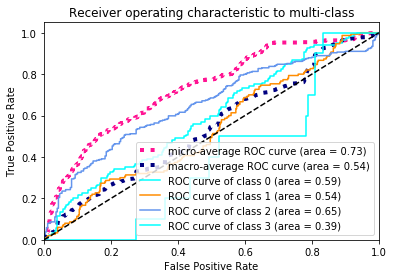

In [216]:
# fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_out)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_stage[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_stage.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Clustering using k-Means

In [218]:
extract = Model(model.input, model.layers[-2].output) # Dense(128,...)
features = extract.predict(X_train_stage)

In [88]:
features.shape

(5320, 1024)

In [89]:
test_features = extract.predict(X_test)

In [90]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(features)

In [91]:
labels = kmeans.labels_

In [92]:
labels.shape

(5320,)

In [93]:
pred = kmeans.predict(test_features)

In [94]:
kmeans.cluster_centers_

array([[8.4246640e-05, 3.7524058e-03, 1.0665223e-03, ..., 3.3916805e-02,
        6.8606412e-01, 0.0000000e+00],
       [1.4042598e-09, 4.0087536e-02, 1.3213139e-08, ..., 4.2540319e-03,
        3.6525851e-01, 0.0000000e+00]], dtype=float32)

In [95]:
y_train_flat = []
for i in range(len(y_train)):
    y_train_flat.append(np.where(y_train[i]==1)[0][0])
    
sum(y_train_flat), len(y_train_flat)

(3734, 5320)

In [96]:
labels

array([1, 1, 0, ..., 0, 0, 0], dtype=int32)

In [97]:
cluster_1_pd = 0
cluster_2_pd = 0
cluster_1_c = 0
cluster_2_c = 0
cluster_1 = 0
cluster_2 = 0
for i in range(len(labels)):
    if labels[i] == 0:
        cluster_1 += 1
        if y_train_flat[i] == 1: cluster_1_pd += 1
        elif y_train_flat[i] == 0: cluster_1_c += 1
    elif labels[i] == 1:
        cluster_2 += 1
        if y_train_flat[i] == 1: cluster_2_pd += 1
        elif y_train_flat[i] == 0: cluster_2_c += 1
    else:
        print('idk')
        
cluster_1, cluster_2
#     print(labels[i], y_train_flat[i])

(3386, 1934)

In [98]:
cluster_1_pd/cluster_1, cluster_1_c/cluster_1

(0.7058476077968104, 0.2941523922031896)

In [99]:
cluster_2_pd/cluster_2, cluster_2_c/cluster_2

(0.6949327817993796, 0.3050672182006205)

In [239]:
extract = Model(model.input, model.layers[-2].output) # Dense(128,...)
features = extract.predict(X_train_stage)
features.shape

(6080, 1024)

In [240]:
test_features = extract.predict(X_test_stage)

In [241]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(features)
labels = kmeans.labels_
labels.shape

(6080,)

In [242]:
kmeans.cluster_centers_

array([[ 0.0000000e+00,  1.5230014e-05,  1.0424478e+00, ...,
         0.0000000e+00,  1.4418008e-02,  0.0000000e+00],
       [ 0.0000000e+00,  9.0949470e-13,  1.8650726e+02, ...,
         0.0000000e+00,  9.3132257e-10,  0.0000000e+00],
       [ 0.0000000e+00,  9.0949470e-13,  2.4084396e+01, ...,
         0.0000000e+00, -9.3132257e-09,  0.0000000e+00],
       [ 0.0000000e+00,  3.7289283e-11,  8.6861506e+00, ...,
         0.0000000e+00,  2.2351742e-08,  0.0000000e+00]], dtype=float32)

In [243]:
y_train_flat = []
for i in range(len(y_train_stage)):
    y_train_flat.append(np.where(y_train_stage[i]==1)[0][0])
    
sum(y_train_flat), len(y_train_flat)

(6460, 6080)

In [245]:
cluster_1, cluster_2, cluster_3, cluster_4 = [], [], [], []
for i in range(len(labels)):
    if labels[i] == 0:
        cluster_1.append(y_train_flat[i])
    elif labels[i] == 1:
        cluster_2.append(y_train_flat[i])
    elif labels[i] == 2:
        cluster_3.append(y_train_flat[i])
    elif labels[i] == 3:
        cluster_4.append(y_train_flat[i])
    else:
        print('idk')
        
len(cluster_1), len(cluster_2), len(cluster_3), len(cluster_4)
#     print(labels[i], y_train_flat[i])

(5646, 20, 79, 335)

In [271]:
def get_cluster_details(cluster):
    d = {}
    for x in cluster:
        if d.get(x):
            d[x] +=1 
        else:
            d[x] = 1
    
    ls = []
    for i in sorted(d):
        print('percentage for %f: %f' %(i, d[i]/len(cluster)))
        ls.append(d[i]/len(cluster))
    return d, len(cluster), ls

get_cluster_details(cluster_1)

percentage for 0.000000: 0.303224
percentage for 1.000000: 0.332448
percentage for 2.000000: 0.364329


({1: 1877, 0: 1712, 2: 2057},
 5646,
 [0.30322352107686856, 0.3324477506199079, 0.36432872830322355])

In [272]:
get_cluster_details(cluster_2)

percentage for 2.000000: 1.000000


({2: 20}, 20, [1.0])

In [273]:
get_cluster_details(cluster_3)

percentage for 0.000000: 0.443038
percentage for 1.000000: 0.113924
percentage for 2.000000: 0.443038


({2: 35, 1: 9, 0: 35},
 79,
 [0.4430379746835443, 0.11392405063291139, 0.4430379746835443])

In [274]:
get_cluster_details(cluster_4)

percentage for 0.000000: 0.397015
percentage for 1.000000: 0.161194
percentage for 2.000000: 0.441791


({1: 54, 2: 148, 0: 133},
 335,
 [0.3970149253731343, 0.16119402985074627, 0.4417910447761194])

In [261]:
stage0 = (1712, 0, 35, 133)
stage1 = (1877, 0, 9, 54)
stage2 = (2057, 20, 35, 148)

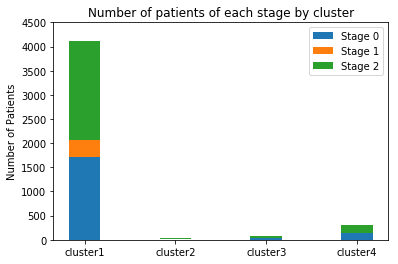

Cluster 1: [0.303, 0.332, 0.364]
Cluster 2: [0.0, 1.0, 0.0]
Cluster 3: [0.443, 0.114, 0.443]
Cluster 4: [0.397, 0.162, 0.441]


In [287]:
import numpy as np
import matplotlib.pyplot as plt


N = 5
# menMeans = (20, 35, 30, 35, 27)
# womenMeans = (25, 32, 34, 20, 25)
# menStd = (2, 3, 4, 1, 2)
# womenStd = (3, 5, 2, 3, 3)

stage0 = (1712, 0, 35, 133)
stage1 = (1877, 0, 9, 54)
stage2 = (2057, 20, 35, 148)

ind = np.arange(4)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, stage0, width)
p2 = plt.bar(ind, stage1, width,
             bottom=stage0)
p3 = plt.bar(ind, stage2, width,
             bottom=stage2)

plt.ylabel('Number of Patients')
plt.title('Number of patients of each stage by cluster')
plt.xticks(ind, ('cluster1', 'cluster2', 'cluster3', 'cluster4'))
plt.yticks(np.arange(0, 5000, 500))
plt.legend((p1[0], p2[0], p3[0]), ('Stage 0', 'Stage 1', 'Stage 2'))

plt.show()

print('Cluster 1:', [0.303, 0.332, 0.364])
print('Cluster 2:', [0.0, 1.0, 0.0])
print('Cluster 3:', [0.443, 0.114, 0.443])
print('Cluster 4:', [0.397, 0.162, 0.441])

# PCA on PD vs Control Data

In [85]:
pca = PCA(2)

In [86]:
projected = pca.fit_transform(X_train)

ValueError: Found array with dim 4. Estimator expected <= 2.